# 0. Imports and Toy Dataset Creation

In [1]:
import networkx as nx
import torch
from collections import deque
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import (
    adjusted_mutual_info_score as AMI,
    adjusted_rand_score as ARI,
)

In [2]:
import numpy as np
np.random.seed(42)

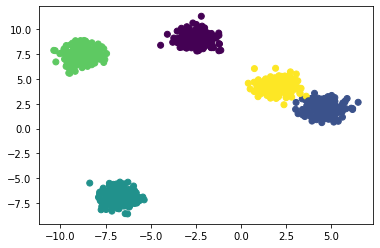

In [3]:
X, y, centroids_true = make_blobs(
    n_samples=1000,
    centers=5,
    cluster_std=0.6,
    return_centers=True
)
plt.scatter(X[:,0], X[:,1], c=y);

In [4]:
class DBSCANBase:
    def __init__(self, eps, minPts):
        self._eps = eps
        self._minPts = minPts

    def fit(self, X):
        pass

    def score(self, X, y):
        y_pred = self.predict(X)
        return (AMI(y, y_pred), ARI(y, y_pred))

    def predict(self, X):
        pass

# 1. Naive Implementation Using BFS on Distance Graph

This doesn't work yet although it should in theory, need to figure out why.

In [5]:
class DBSCANGraphBased(DBSCANBase):
    def fit(self, X):
        self._construct_graph(X)
        self._get_clusters()
        self._get_centroids(X)
        self._cluster_outliers(X)

    def predict(self, X):
        y = []
        for x in X:
            distances = {
                label: self._distance(x, centroid)
                for label, centroid in self._centroids.items()
            }
            y.append(min(distances, key=distances.get))
        return y

    def _construct_graph(self, X):
        cardinality = len(X)
        graph = nx.Graph()
        graph.add_nodes_from(
            list(range(cardinality)), is_core=False, visited=False, cluster=None
        )
        for i in range(cardinality):
            for j in range(i + 1, cardinality):
                if self._distance(X[i], X[j]) < self._eps:
                    graph.add_edge(i, j)
            if graph.degree[i] >= self._minPts:
                graph.nodes[i]["is_core"] = True
        self._graph = graph

    def _get_clusters(self):
        cluster_label = 0
        for node in self._graph:
            if not self._graph.nodes[node]["visited"] and self._graph.nodes[node][
                "is_core"
            ]:
                self._graph.nodes[node]["visited"] = True
                self._graph.nodes[node]["cluster"] = cluster_label
                self._bfs_node(node, cluster_label)
                cluster_label += 1
        self._num_clusters = cluster_label

    def _bfs_node(self, source, cluster_label):
        neighbors = self._graph.neighbors
        queue = deque([(source, len(self._graph), neighbors(source))])
        while queue:
            _, depth_now, children = queue[0]
            try:
                child = next(children)
                if not self._graph.nodes[child]["visited"]:
                    self._graph.nodes[child]["visited"] = True
                    self._graph.nodes[child]["cluster"] = cluster_label
                    if depth_now > 1:
                        queue.append((child, depth_now - 1, neighbors(child)))
            except StopIteration:
                queue.popleft()

    def _get_centroids(self, X):
        self._centroids = {}
        for i in range(self._num_clusters):
            X_list = []
            for node in self._graph:
                if self._graph.nodes[node]["cluster"] == i:
                    X_list.append(X[i])
            self._centroids.update({i: np.mean(X_list, axis=0)})

    def _cluster_outliers(self, X):
        for node in self._graph:
            if self._graph.nodes[node]["cluster"] is None:
                self._graph.nodes[node]["cluster"] = self.predict(X[node])

    @staticmethod
    def _distance(p1, p2):
        return np.linalg.norm(p1 - p2)


AMI: 0.6797035317782859, ARI: 0.4098461733341914


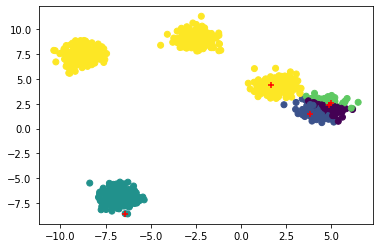

In [6]:
clusterer = DBSCANGraphBased(0.4, 2*X.shape[1])
clusterer.fit(X)
ami, ari = clusterer.score(X, y)
print(f'AMI: {ami}, ARI: {ari}')
y_pred = clusterer.predict(X)
best_centroids = np.array(
    [centroid for centroid in clusterer._centroids.values()]
)
plt.scatter(X[:,0], X[:,1], c=y_pred);
plt.scatter(best_centroids[:,0], best_centroids[:,1], marker='+', color='red');

In [7]:
%timeit DBSCANGraphBased(0.4, 2*X.shape[1]).fit(X)

1.29 s ± 4.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 2. Vectorized Implementation With Implicit DFS on Distance Matrix

In [8]:
class DBSCANVectorized(DBSCANBase):
    def fit(self, X):
        dist_matrix = self._get_distance_matrix(X)

        # initialization
        cluster = 1
        n_objs = X.shape[0]
        labels = np.zeros(n_objs)

        for i in range(n_objs):
            if not labels[i]:
                neighbors = self._get_nearest_neighbours(dist_matrix[i])
                if (
                    len(neighbors) > self._minPts
                ):  # not >= because self is included in neighbours
                    labels[i] = cluster
                    labels = self._expand_cluster(
                        dist_matrix, neighbors, cluster, labels
                    )
                    cluster += 1

        self._centroids = self._get_centroids(X, labels, cluster - 1)
        return labels

    def predict(self, X):
        X = X[None, ...]
        centroids = self._centroids[:, None, ...]
        all_diff = X - centroids
        all_dist = np.sqrt(np.einsum("...k, ...k -> ...", all_diff, all_diff))
        return np.argmin(all_dist, axis=0)

    @staticmethod
    def _get_distance_matrix(X):
        # reimplement cdist
        diff_mat = X[:, None] - X[None, :]
        return np.sqrt(np.einsum("...k, ...k -> ...", diff_mat, diff_mat))

    def _get_centroids(self, X, labels, last_cluster):
        return np.array(
            [
                np.mean(X[np.where(labels == i)], axis=0)
                for i in range(1, last_cluster + 1)
            ]
        )

    def _get_nearest_neighbours(self, x):
        return np.where(x <= self._eps)[0]

    def _expand_cluster(self, X, neighbors, cluster, labels):
        for neighbor in neighbors:
            if not labels[neighbor]:  # if point is unassigned
                neighbors_of_neighbor = self._get_nearest_neighbours(X[neighbor])
                if len(neighbors_of_neighbor) >= self._minPts:  # if point is core
                    labels[neighbor] = cluster
                    labels = self._expand_cluster(
                        X, neighbors_of_neighbor, cluster, labels
                    )
        return labels


AMI: 0.9960669625875377, ARI: 0.9974962343264018


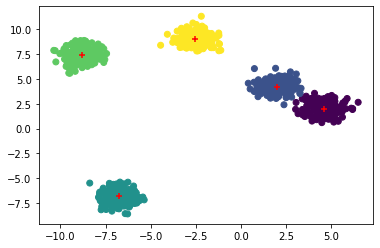

In [9]:
clusterer = DBSCANVectorized(0.4, 2*X.shape[1])
clusterer.fit(X)
ami, ari = clusterer.score(X, y)
print(f'AMI: {ami}, ARI: {ari}')
y_pred = clusterer.predict(X)
best_centroids = np.array(
    [centroid for centroid in clusterer._centroids]
)
plt.scatter(X[:,0], X[:,1], c=y_pred);
plt.scatter(best_centroids[:,0], best_centroids[:,1], marker='+', color='red');

In [10]:
%timeit DBSCANVectorized(0.4, 2*X.shape[1]).fit(X)

24.5 ms ± 93.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 3. GPU Accelerated Implementation

In [11]:
class DBSCANTorch(DBSCANBase): # TODO: Why is this slower than numpy?
    def fit(self, X):
        self._X = torch.tensor(X, device="cuda")

        dist_matrix = self._get_distance_matrix()

        # initialization
        cluster = 1
        n_objs = self._X.shape[0]
        labels = torch.zeros(n_objs, device="cuda")

        for i in range(n_objs):
            if not labels[i]:
                neighbors = self._get_nearest_neighbours(dist_matrix[i])
                if (
                    len(neighbors) > self._minPts
                ):  # not >= because self is included in neighbours
                    labels[i] = cluster
                    labels = self._expand_cluster(
                        dist_matrix, neighbors, cluster, labels
                    )
                    cluster += 1

        self._centroids = self._get_centroids(labels, cluster - 1)
        return labels

    def predict(self, X, as_numpy=True):
        X = torch.tensor(X[None, ...], device="cuda")
        centroids = self._centroids[:, None, ...]
        all_diff = X - centroids
        all_dist = torch.einsum("...k, ...k -> ...", all_diff, all_diff).sqrt()
        preds = torch.argmin(all_dist, dim=0)
        if as_numpy:
            return preds.cpu().numpy()
        else:
            return preds
    
    def _get_distance_matrix(self):
        # reimplement cdist
        diff_mat = self._X[:, None] - self._X[None, :]
        return torch.einsum("...k, ...k -> ...", diff_mat, diff_mat).sqrt()

    def _get_centroids(self, labels, last_cluster):
        return torch.stack(
            [
                self._X[torch.where(labels == i)].mean(dim=0)
                for i in range(1, last_cluster + 1)
            ]
        )

    def _get_nearest_neighbours(self, x):
        return torch.where(x <= self._eps)[0]

    def _expand_cluster(self, X, neighbors, cluster, labels):
        for neighbor in neighbors:
            if not labels[neighbor]:  # if point is unassigned
                neighbors_of_neighbor = self._get_nearest_neighbours(X[neighbor])
                if len(neighbors_of_neighbor) >= self._minPts:  # if point is core
                    labels[neighbor] = cluster
                    labels = self._expand_cluster(
                        X, neighbors_of_neighbor, cluster, labels
                    )
        return labels

AMI: 0.9960669625875377, ARI: 0.9974962343264018


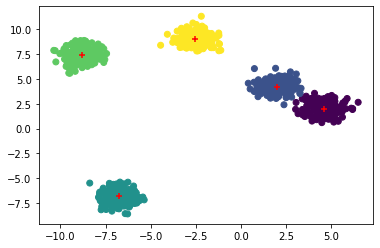

In [12]:
clusterer = DBSCANTorch(0.4, 2*X.shape[1])
clusterer.fit(X)
ami, ari = clusterer.score(X, y)
print(f'AMI: {ami}, ARI: {ari}')
y_pred = clusterer.predict(X)
best_centroids = np.array(
    [centroid for centroid in clusterer._centroids.cpu().numpy()]
)
plt.scatter(X[:,0], X[:,1], c=y_pred);
plt.scatter(best_centroids[:,0], best_centroids[:,1], marker='+', color='red');

In [13]:
%timeit DBSCANTorch(0.4, 2*X.shape[1]).fit(X)

396 ms ± 3.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
